In [5]:
%load_ext autoreload
%autoreload 

import sys
import os
#Import libraries
from lcz_classification.config import *
import h5py
import numpy as np
import rasterio as r
import rioxarray as rio
from rasterio.plot import show, show_hist
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pylab as pl
import os
import ipywidgets as widgets
from matplotlib.pyplot import imshow
from sklearn.decomposition import PCA
from affine import Affine

## Import GeFOLKI Functionalities
import sys
sys.path.append('../lcz_classification/gefolki/python')
from algorithm import EFolki
from tools import wrapData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
prisma_fp = r"D:\GeoAI\projects\lcz_classification\data\cairo\raw\prisma\PRS_L2D_STD_20210807084732_20210807084737_0001\PRS_L2D_STD_20210807084732_20210807084737_0001.he5"
prisma_ref_fp='../data/cairo/raw/prisma/prisma_ref.tif'
f = h5py.File(prisma_fp, 'r')
attrs=f.attrs

In [7]:
data = f['HDFEOS']['SWATHS']['PRS_L2D_HCO']

lat = np.array(data['Geolocation Fields']['Latitude'][:])
lon = np.array(data['Geolocation Fields']['Longitude'][:])


bbox=[lon.min(), lat.min(), lon.max(), lat.max()]
x1,y1,x2,y2 = bbox

pixel_height = (lat[1, 0] - lat[0, 0])
pixel_width = (lon[0, 1] - lon[0, 0])

# Create affine transform
transform = Affine(pixel_width, 0, x1,
                    0, pixel_height, y2)
# bbox_gdf=gpd.GeoDataFrame(geometry=[box(*bbox)], crs='EPSG:4326')

### Get Indices of R,G, B and NIR

In [8]:
# Attributes
attrs = f.attrs

# Wavelengths (separately for VNIR and SWIR)
vn_wvl = np.array([wvl for wvl in attrs['List_Cw_Vnir']])
sw_wvl = np.array([wvl for wvl in attrs['List_Cw_Swir']])


## VNIR BANDS - REVERSED
vnir_bands = f.attrs['List_Cw_Vnir']
vnir_dict = {}

for i, band in enumerate(vnir_bands):
    vnir_dict[len(vnir_bands) - i] = band

vnir_keys = list(vnir_dict.keys())

## SWIF BANDS - REVERSED
swir_bands = f.attrs['List_Cw_Swir']
swir_dict = {}

for i, band in enumerate(swir_bands):
    swir_dict[len(swir_bands) - i] = band

swir_keys = list(swir_dict.keys())


# Index of NIR red, green and blue in the VNIR cube
idx_nir = 51
idx_red = 33
idx_green = 23
idx_blue = 11

# print(f"NIR wvl: {vnir_dict[idx_nir]:.3f}, \nRed wvl: {vnir_dict[idx_red]:.3f}, \nGreen wvl: {vnir_dict[idx_green]:.3f}, \nBlue wvl: {vnir_dict[idx_blue]:.3f}")

# #Index of the NIR(849 nm - Band 51) Red (660.26361nm - Band 33), Blue (478.1763nm - Band 11), and Green (571.00281nm - Band 23) bands:
idx_nir_prisma = vnir_keys.index(idx_nir)
idx_red_prisma = vnir_keys.index(idx_red)
idx_green_prisma = vnir_keys.index(idx_green)
idx_blue_prisma = vnir_keys.index(idx_blue)
print(f"The NIR band number {idx_nir} has position {idx_nir_prisma}")
print(f"The Red band number {idx_red} has position {idx_red_prisma}")
print(f"The Green band number {idx_green} has position {idx_green_prisma}")
print(f"The Blue band number {idx_blue} has position {idx_blue_prisma}")


The NIR band number 51 has position 15
The Red band number 33 has position 33
The Green band number 23 has position 43
The Blue band number 11 has position 55


In [9]:
vrf = np.array(data['Data Fields']['VNIR_Cube'][:]) 
srf = np.array(data['Data Fields']['SWIR_Cube'][:]) 
print(vrf.shape)
print(srf.shape)

#move the number of wavelengths to the last position:
vrf = np.moveaxis(vrf, 1, 2)
srf = np.moveaxis(srf, 1, 2)
print(vrf.shape)
print(srf.shape)


L2ScaleVnirMax = attrs['L2ScaleVnirMax']
L2ScaleVnirMin = attrs['L2ScaleVnirMin']
L2ScaleSwirMax = attrs['L2ScaleSwirMax']
L2ScaleSwirMin = attrs['L2ScaleSwirMin']
print(f"VNIR min: {L2ScaleVnirMin:.3f}, VNIR max: {L2ScaleVnirMax:.3f}")
print(f"SWIR min: {L2ScaleSwirMin:.3f}, SWIR max: {L2ScaleSwirMax:.3f}")

SR_scaler = 65535

vrf_refl = L2ScaleVnirMin + vrf*(L2ScaleVnirMax - L2ScaleVnirMin) / SR_scaler
srf_refl = L2ScaleSwirMin + srf*(L2ScaleSwirMax - L2ScaleSwirMin) / SR_scaler

PRISMA_NirBand = vrf_refl[:, :, idx_nir_prisma]
PRISMA_RedBand = vrf_refl[:, :, idx_red_prisma]
PRISMA_GreenBand = vrf_refl[:, :, idx_green_prisma]
PRISMA_BlueBand = vrf_refl[:, :, idx_blue_prisma]


(1220, 66, 1256)
(1220, 173, 1256)
(1220, 1256, 66)
(1220, 1256, 173)
VNIR min: 0.000, VNIR max: 0.826
SWIR min: 0.000, SWIR max: 1.000


## Co-Registeration of PRISMA and Sentinel-2 Images using GeFOLKI

#### Read Sentinel-2 Image

In [10]:


with r.open(S2_FP) as src:
    # Read the data from the red, green, and blue bands
    data = src.read() * S2_SCALE
    # Get the metadata of the source image
    # src_meta = src.meta
    # dst_meta = src_meta.copy()

    Sentinel2_NirBand = data[3]
    Sentinel2_RedBand = data[2]
    Sentinel2_GreenBand = data[1]
    Sentinel2_BlueBand = data[0]




In [12]:
iteration = 4
radius = [100, 100]
rank = 4
level = 5
band_sel='Red'


bands_dict_PRISMA = {'Blue':PRISMA_BlueBand,
             'Green':PRISMA_GreenBand,
             'Red':PRISMA_RedBand,
             'NIR':PRISMA_NirBand}

bands_dict_S2 = {'Blue':Sentinel2_BlueBand,
             'Green':Sentinel2_GreenBand,
             'Red':Sentinel2_RedBand,
             'NIR':Sentinel2_NirBand}


#band coregistration
mask_pr = bands_dict_PRISMA[band_sel]>0

PRISMA_Band = bands_dict_PRISMA[band_sel]*mask_pr
Sentinel2_Band = bands_dict_S2[band_sel]
Sentinel2_Band = Sentinel2_Band[:PRISMA_Band.shape[0], :PRISMA_Band.shape[1]]
Sentinel2_Band = Sentinel2_Band*mask_pr

print("Started - GeFolki coregistration")

# u, v = EFolki(WV, QB, iteration=4, radius=[16,8], rank=4, levels=5)
# u, v = EFolki(Sentinel2_Band, PRISMA_Band, iteration=iteration, radius=radius, rank=rank, levels=level)
u, v = EFolki(Sentinel2_Band, PRISMA_Band, iteration=4, radius=[16,8], rank=4, levels=5)
print("Completed - GeFolki coregistration")


print(f"u matrix shape --> {u.shape}")
print(f"v matrix shape --> {v.shape}")



Started - GeFolki coregistration
Completed - GeFolki coregistration
u matrix shape --> (1220, 1256)
v matrix shape --> (1220, 1256)


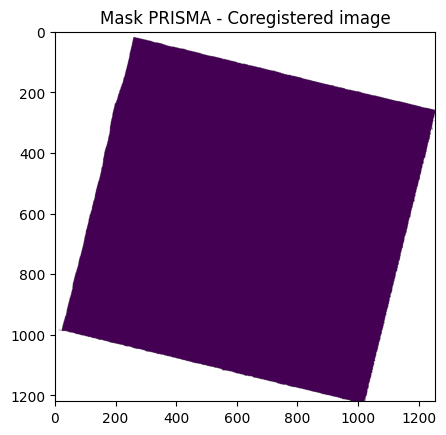

In [13]:

PRISMArecalee_vrf = np.zeros(vrf.shape)
PRISMArecalee_srf = np.zeros(srf.shape)


for idx, band in enumerate(vn_wvl):
    PRISMArecalee_vrf[:, :, idx] = wrapData(vrf_refl[:, :, idx], u, v)


for idx, band in enumerate(sw_wvl):
    PRISMArecalee_srf[:, :, idx] = wrapData(srf_refl[:, :, idx], u, v)



# Mask for coregistered imagery
outside_mask_coreg = np.amax(PRISMArecalee_vrf, axis=2).astype(float)
outside_mask_coreg[outside_mask_coreg != 0] = 1
outside_mask_coreg[outside_mask_coreg == 0] = np.nan
plt.imshow(outside_mask_coreg)
plt.title("Mask PRISMA - Coregistered image");





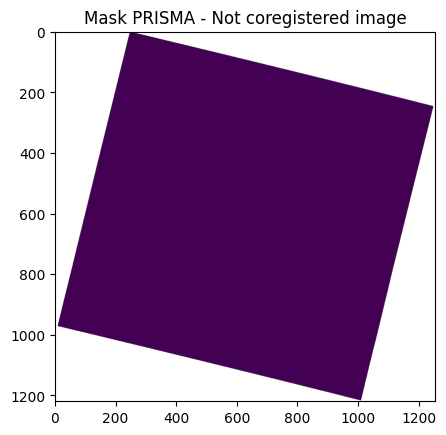

In [14]:
# Mask for NOT coregistered imagery
outside_mask_not_coreg = np.amax(vrf, axis=2).astype(float)
outside_mask_not_coreg[outside_mask_not_coreg != 0] = 1
outside_mask_not_coreg[outside_mask_not_coreg == 0] = np.nan
plt.imshow(outside_mask_not_coreg)
plt.title("Mask PRISMA - Not coregistered image");




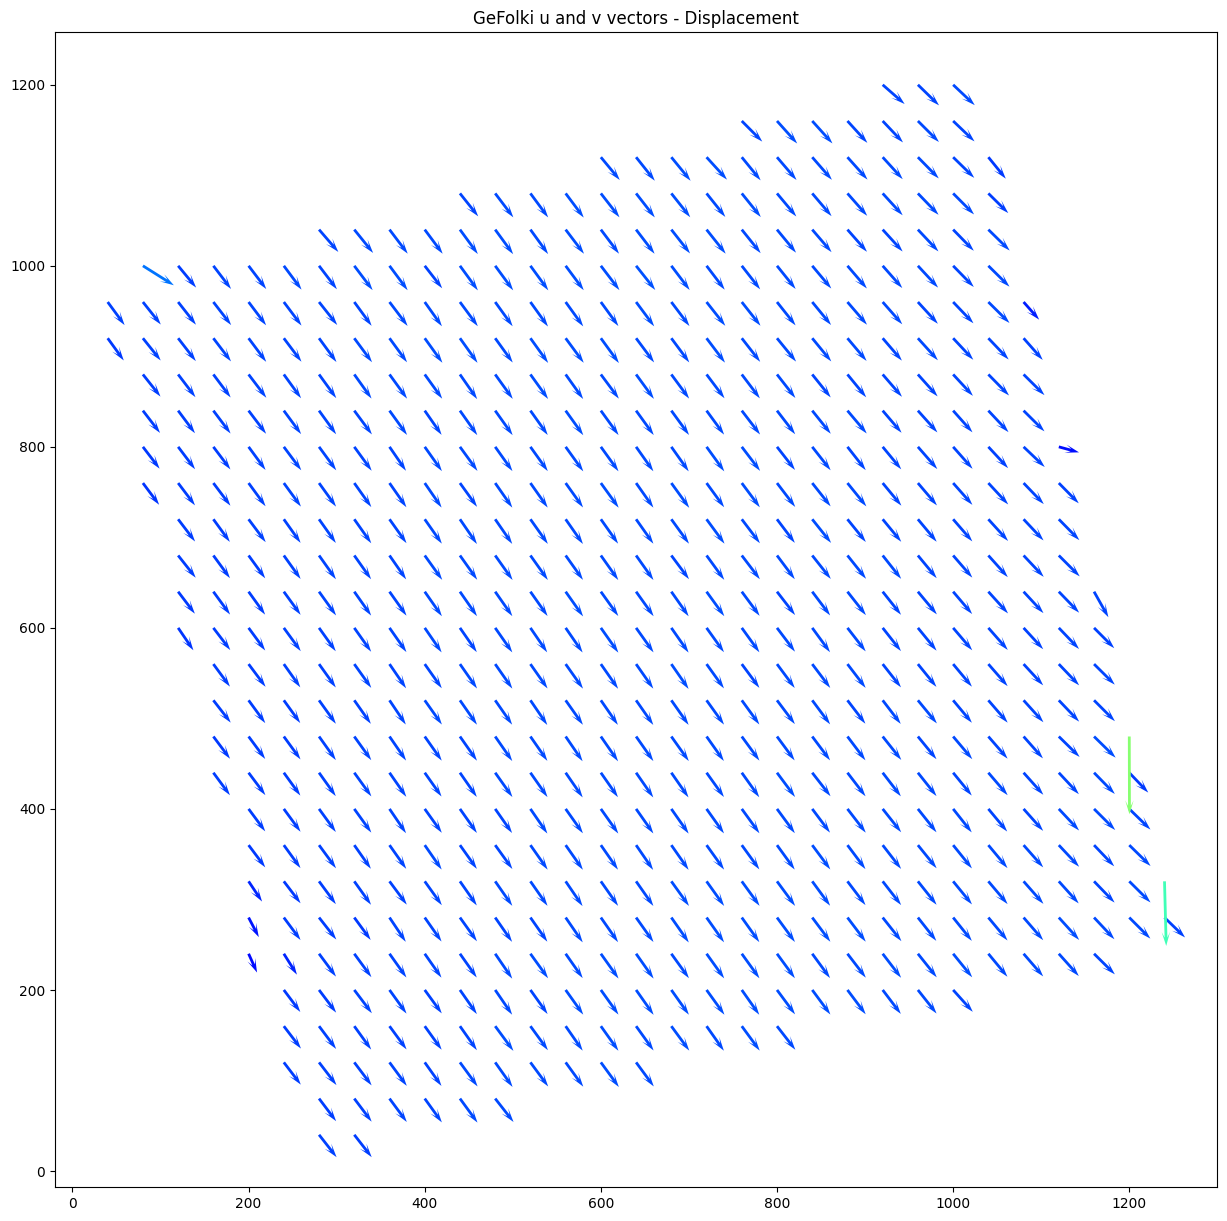

In [15]:
# Create a meshgrid for the coordinates
X, Y = np.meshgrid(np.arange(0, v.shape[1]), np.arange(0, v.shape[0]))

#Remove quivers outside the image region
X = X * outside_mask_coreg
Y = Y * outside_mask_coreg

#Keep every 40 quivers to not have too many of them
skip = 40
X_subset = X[::skip, ::skip]
Y_subset = Y[::skip, ::skip]
u_subset = -u[::skip, ::skip]
v_subset = v[::skip, ::skip]
# Compute the vector length
uv_length = np.sqrt(u_subset**2 + v_subset**2)

fig, ax = plt.subplots(figsize=(15, 15))
widths = np.linspace(0, 100, X.size)
ax.quiver(X_subset, Y_subset, u_subset, v_subset, uv_length, cmap='jet', headaxislength=3)
plt.title("GeFolki u and v vectors - Displacement")
plt.show()


u_masked =  u * outside_mask_coreg
v_masked = v * outside_mask_coreg




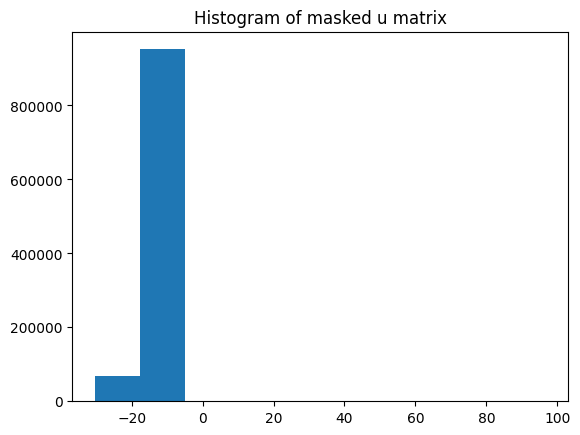

In [16]:
plt.hist(u_masked.flatten());
plt.title("Histogram of masked u matrix");

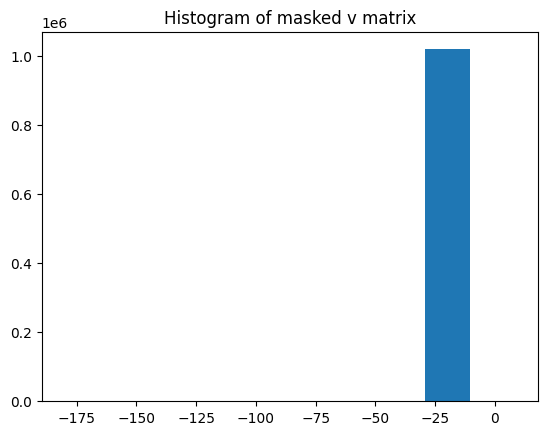

In [17]:

plt.hist(v_masked.flatten());
plt.title("Histogram of masked v matrix");

In [18]:
print(f"Mean of u: {np.nanmean(u_masked):.2f} | STD: {np.nanstd(u_masked):.2f} | Median: {np.nanmedian(u_masked):.2f}")
print(f"Mean of v: {np.nanmean(v_masked):.2f} | STD: {np.nanstd(v_masked):.2f} | Median: {np.nanmedian(v_masked):.2f}")

Mean of u: -15.57 | STD: 1.71 | Median: -15.35
Mean of v: -20.37 | STD: 3.05 | Median: -20.53


In [19]:

print("Started - GeFolki coregistration")
u_check, v_check = EFolki(Sentinel2_Band, PRISMArecalee_srf[:, :, 32], iteration=iteration, radius=radius, rank=rank, levels=level) #32 is red band index - CHANGE INDEX IF WANT TO TEST WITH OTHER BANDS
print("Completed - GeFolki coregistration")

Started - GeFolki coregistration
Completed - GeFolki coregistration


In [20]:

u_check_masked =  u_check * outside_mask_coreg
v_check_masked = v_check * outside_mask_coreg

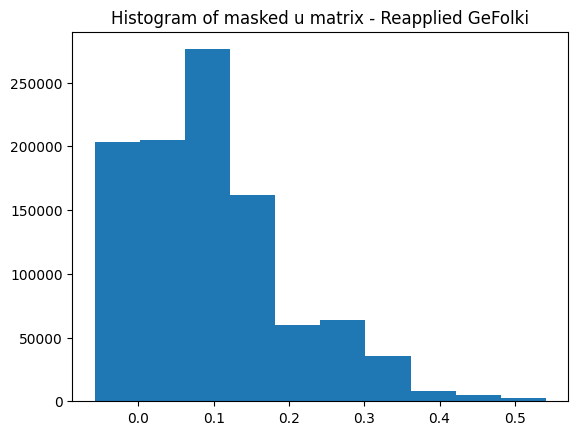

In [21]:

plt.hist(u_check_masked.flatten());
plt.title("Histogram of masked u matrix - Reapplied GeFolki");

## Export Coregistered PRISMA Imagery

In [27]:

#Create a folder for coregistered images
if not os.path.exists(f"../data/cairo/processed/prisma"):
    os.makedirs(f"../data/cairo/processed/prisma")

In [29]:
kwargs = {}
kwargs['driver'] = 'GTiff'
kwargs['dtype'] = 'float32'
kwargs['count'] = 1
kwargs['width'] = PRISMArecalee_vrf.shape[1]
kwargs['height'] = PRISMArecalee_vrf.shape[0]
kwargs['dtype'] = 'float32'
kwargs['crs'] = src.crs
kwargs['transform'] = r.transform.Affine(CELL_RESOLUTION, src.transform[1],src.transform[2], src.transform[3], -CELL_RESOLUTION, src.transform[5])

In [ ]:

for i in range(0, PRISMArecalee_vrf.shape[2]):
    name = f'vnir_b{str(vnir_keys[i])}_30m.tif'
    with r.open(os.path.join(f"../data/cairo/processed/prisma/coregistered", name), 'w', **kwargs) as dst:
        dst.write_band(1, PRISMArecalee_vrf[:, :, i].astype(r.float32))

In [ ]:

for i in range(0, PRISMArecalee_srf.shape[2]):
    name = f'swir_{str(swir_keys[i])}_30m.tif'
    with r.open(os.path.join(f"../data/cairo/processed/prisma/coregistered", name), 'w', **kwargs) as dst:
        dst.write_band(1, PRISMArecalee_srf[:, :, i].astype(r.float32))

# Export complete coregistered imagery (useful for spectral signature plotting)
NOTE: also bands with all zero values are kept for completeness. They can be removed easily when they are imported. The zero bands are removed in the following notebooks when the image is imported.

In [ ]:
PRISMArecalee_vrf_sorted = np.flip(PRISMArecalee_vrf, axis=2)
PRISMArecalee_srf_sorted = np.flip(PRISMArecalee_srf, axis=2)
PRISMArecalee_sorted = np.dstack((PRISMArecalee_vrf_sorted, PRISMArecalee_srf_sorted))
PRISMArecalee_sorted = np.moveaxis(PRISMArecalee_sorted, -1, 0)
PRISMArecalee_sorted.shape
kwargs = {}
kwargs['driver'] = 'GTiff'
kwargs['dtype'] = 'float32'
kwargs['count'] = PRISMArecalee_sorted.shape[0]
kwargs['width'] = PRISMArecalee_sorted.shape[2]
kwargs['height'] = PRISMArecalee_sorted.shape[1]
kwargs['dtype'] = 'float32'
kwargs['crs'] = src.crs
kwargs['transform'] = r.transform.Affine(CELL_RESOLUTION, src.transform[1],src.transform[2], src.transform[3], -CELL_RESOLUTION, src.transform[5])

with r.open('../data/cairo/processed/prisma/coregistered/PR_30m.tif', 'w', **kwargs) as dst:
    dst.write(PRISMArecalee_sorted.astype(r.float32))